In [31]:
%load_ext autoreload
%autoreload 2

import random
import anaconfig
import os
import os.path as op

from tqdm.auto import tqdm
import numpy.typing as npt
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils.commonutils.crun import run_for_different_partitions
from utils.commonutils.config import (
    get_pipeline_config_path,cdirs, load_config, resolve_config_paths
)
from utils.commonutils.ctests import get_required_test_dataset_names
from utils.plotutils.plotconfig import configure_matplotlib
from scripts.evaluate import evaluate_partition

configure_matplotlib()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
partition = "minbias-sim10b-xdigi_v2.4_1498"
experiment_name = "scifi-5"

config_path = get_pipeline_config_path(experiment_name)
config = load_config(config_path)
data_experiment_dir = op.join(
    cdirs.data_directory, config["common"]["experiment_name"]
)

In [14]:
from Embedding.models.layerless_embedding import LayerlessEmbedding
from utils.modelutils import checkpoint_utils

embedding_version_dir = checkpoint_utils.get_last_version_dir_from_config(
    step="metric_learning", path_or_config=config_path,
)
embedding_metric_path = op.join(embedding_version_dir, "metrics.csv")
embedding_artifact_path = checkpoint_utils.get_last_artifact(
    version_dir=embedding_version_dir
)
print(f"{embedding_metric_path=}")
print(f"{embedding_artifact_path=}")

metric_learning_model = LayerlessEmbedding.load_from_checkpoint(
    embedding_artifact_path,
    hparams=config["metric_learning"],
)


embedding_metric_path='/home/acorreia/etx4velo/etx4velo/artifacts/metric_learning/scifi-5/version_27/metrics.csv'
embedding_artifact_path='/home/acorreia/etx4velo/etx4velo/artifacts/metric_learning/scifi-5/version_27/checkpoints/epoch=52-step=284875.ckpt'


In [33]:
from Processing.planewise_edges import get_planewise_edges

# Load one event
batch_dir = op.join(data_experiment_dir, "processed", "test", partition)
inpaths = [file_.path for file_ in os.scandir(batch_dir) if file_.is_file and file_.name != "done"]
path = filenames[random.randint(0, len(filenames))]


df_particles = pd.read_parquet(batch.truncated_path + "-particles.parquet", columns=["particle_id", "eta"])
df_particles["in_acceptance"] = (df_particles["eta"] > 2.0) & (df_particles["eta"] < 5.0)


In [37]:
print(batch.keys)

['zatyeq0', 'truncated_path', 'xatyeq0', 'nhits_scifi', 'event_str', 'particle_id_hit_idx', 'edge_index', 'dxdy', 'y', 'plane', 'fake', 'x', 'hit_id', 'signal_true_edges']


In [130]:
from joblib import Parallel, delayed


bin_edges = np.arange(0, 101, 5) + 0.5

plane_to_histogram = {
    plane: np.zeros(shape=bin_edges.shape[0] - 1, dtype=int)
    for plane in range(12)
}

def get_df_edges(
    edge_indices: npt.ArrayLike,
    df_hits: pd.DataFrame,
    **kwargs,
) -> pd.DataFrame:
    edge_indices = np.asarray(edge_indices)
    df_edges = pd.DataFrame(
        {
            "hit_idx_left": edge_indices[0],
            "hit_idx_right": edge_indices[1],
            **kwargs,
        },
    )

    # Add particle ID information
    for side in ["left", "right"]:
        df_edges = df_edges.merge(
            df_hits.rename(  # type: ignore
                columns={column: f"{column}_{side}" for column in df_hits.columns}
            ),
            on=f"hit_idx_{side}",
            how="left",
        )

    return df_edges


for path in tqdm(inpaths[:200]):
    batch = torch.load(path, map_location="cuda")
    outputs = metric_learning_model.inference(
        batch=batch,
        squared_distance_max=0.01,
        k_max=100,
        evaluate=False,
        log=False,
    )
    edge_indices = outputs["edge_indices"]
    y_truth = outputs["y_truth"]
    batch["edge_index"] = edge_indices
    batch["y"] = y_truth
    batch = batch.cpu()

    # Dataframe of hits
    df_hits = pd.DataFrame(
        {
            "hit_idx": np.arange(batch["x"].shape[0]),
            "plane": batch["plane"].numpy(),
            **{column: batch[column].numpy() for column in ["xatyeq0", "zatyeq0", "dxdy"]}
        }
    )

    df_edges = get_df_edges(
        edge_indices=batch["edge_index"].numpy(),
        df_hits=df_hits,
    )
    for plane, counts in edges_grouped_by_hits.groupby("plane_left"):
        plane_to_histogram[plane] += np.histogram(counts, bins=bin_edges, density=False)[0].astype(int)


  0%|          | 0/200 [00:00<?, ?it/s]

In [140]:
def plot_n_neighbours_for_planes(planes):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    for plane in planes:
        histogram = plane_to_histogram[plane]
        ax.bar(x=bin_centers, height=histogram / histogram.sum(), width=5.0, label=str(plane), alpha=0.4)
    
    ax.legend()
    ax.set_xlabel("# Neighbours")
    ax.set_ylabel("Abundance")

In [141]:
plot_n_neighbours_for_planes([0, 4])


In [142]:
plot_n_neighbours_for_planes([1, 5, 9])


In [143]:
plot_n_neighbours_for_planes([2, 6, 10])


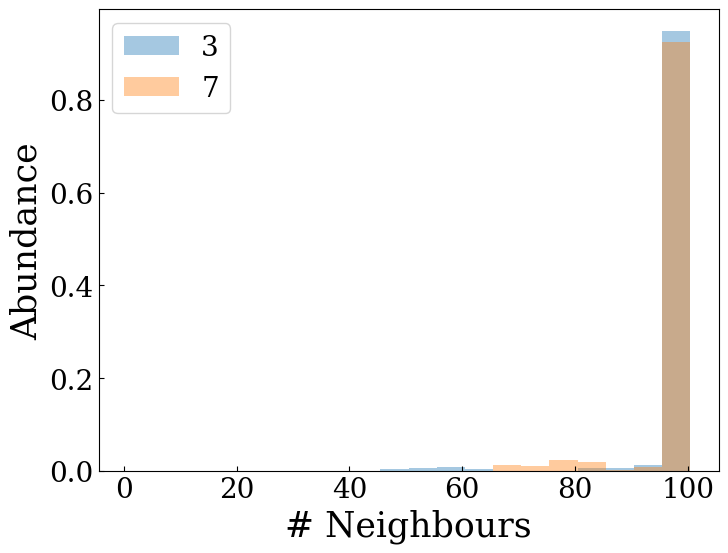

In [144]:
plot_n_neighbours_for_planes([3, 7])
